# Introduction

Brian & barbara wanted a boxplot of genes detected (>= 1.0 FPKM) for the 920 cells in the muscle development paper

Box plot (see seaborn) y axis is number of genes > 1 fpkm.
can use protein coding. should include that in axis.

In [1]:
import numpy
import pandas
import sys
import os
import seaborn
from matplotlib import pyplot
from c1boxplot import boxplot

In [2]:
LONG_RNA_SEQ_DIR = os.path.expanduser('~diane/proj/long-rna-seq-condor')
if LONG_RNA_SEQ_DIR not in sys.path:
    sys.path.append(LONG_RNA_SEQ_DIR)

In [3]:
from woldrnaseq.models import load_gtf_cache
from woldrnaseq.gtfcache import protein_coding_gene_ids

In [4]:
PANDASODF = os.path.expanduser('~diane/src/pandasodf')
if PANDASODF not in sys.path:
    sys.path.append(PANDASODF)
from pandasodf import ODFReader

In [5]:
from find_bigwigs import read_peng_20180710_cluster_memberships

In [6]:
%matplotlib inline

In [7]:
annotation = load_gtf_cache(os.path.expanduser('~diane/proj/genome/mm10-M4-male/mm10-M4-male.h5'))
protein_coding = protein_coding_gene_ids(annotation)

In [8]:
genes_asof17 = pandas.read_csv('C1_mouse_combined_asof_run17.tsv',
                               dtype={0: str},
                               index_col=0,
                               sep='\t')

In [9]:
book = ODFReader('C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods')
clusters = book.parse('Sheet1')
clusters = clusters[['cell_ID', 'cell type cluster 920']]
clusters.shape

(920, 2)

In [10]:
clusters.head()

,cell_ID,cell type cluster 920
0,18317_G10,DarkRed
1,20040_B1,DarkRed
2,20044_A10,DarkRed
3,20042_D4,DarkRed
4,18255_E8,DarkRed


Lets make sure that all the cells in the C1_single_cells_library_number_type_annotation_Jan13_2019 are in the full quantification data table

In [11]:
len(set(clusters.cell_ID).intersection(genes_asof17.columns))

920

In [12]:
protein_genes = genes_asof17.loc[protein_coding][clusters.cell_ID]
protein_genes.shape

(22032, 920)

In [13]:
cluster_label = {
    'DarkRed': 'Muscle 3',
    'red': 'Muscle 2',
    'green': 'Muscle 1',
    'black': 'Mesenchymal cell 2',
    'grey': 'Mesenchymal cell 1',
    'cyan': 'Chondrocyte',
    'orange': 'EMP',
    'yellow': 'Macrophage',
    'purple': 'Endothelium',
    'blue': 'Perichondrial cell',
    'YellowGreen': 'Epithelial cell 2',
    'magenta': 'Neural crest',
    
}

cluster_color = {
    'DarkRed': '#871f4e',
    'red': '#ff8380',
    'green': '#00ff00',
    'black': '#e7e7e7',
    'grey': '#000000',
    'cyan': '#00ffff',
    'orange': '#ff8000',
    'yellow': '#e6e600',
    'purple': '#c39cfb',
    'blue': '#6666ff',
    'YellowGreen': '#84994d',
    'magenta': '#9834e7',
    
}

label_color = { cluster_label[k]: cluster_color[k] for k in cluster_color}

In [14]:
label_to_cluster = {cluster_label[k]: k for k in cluster_label}

In [15]:
cluster_order_by_label = [
    'Muscle 3',
    'Muscle 2',
    'Muscle 1',
    'Perichondrial cell',
    'Chondrocyte',
    'Mesenchymal cell 1',
    'Macrophage',
    'EMP',
    'Epithelial cell 2',
    'Endothelium',
    'Neural crest',
]
cluster_order = [ label_to_cluster[c] for c in cluster_order_by_label]

In [16]:
expressed = protein_genes[protein_genes >= 1]
expressed.shape

(22032, 920)

Force merge two mesenchyme clusters together.

In [17]:
clusters.loc[clusters['cell type cluster 920'] == 'black', 'cell type cluster 920'] = 'grey'

In [18]:
clusters['cluster_name'] = clusters['cell type cluster 920'].apply(lambda x: cluster_label[x])
clusters['color'] = clusters['cell type cluster 920'].apply(lambda x: cluster_color[x])
clusters = clusters.merge(expressed.count().to_frame(name='count'), left_on='cell_ID', right_index=True)

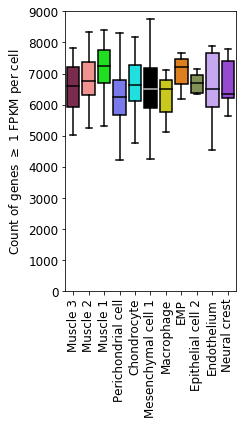

In [19]:
def plot_boxplot(expressed, color_dict, order):
    font_size = 12.0
    
    f = pyplot.figure(figsize=(3.52,6))
    ax = f.add_subplot(1,1,1)
    _ = boxplot(x='cluster_name', y='count', 
                order=order,
                palette=color_dict, 
                data=expressed, 
                showfliers=False,
                ax=ax)
    _ = ax.set_ylabel('Count of genes $\geq$ 1 FPKM per cell', size=font_size)
    _ = ax.set_xlabel('')
    
    labels = ax.get_yticklabels()
    for l in labels:
        l.set_fontsize(font_size)
    
    labels = ax.get_xticklabels()
    for l in labels:
        l.set_text(l.get_text().replace('+', '&\n'))
        l.set_fontsize(font_size)
    _ = ax.set_xticklabels(labels, rotation=90, ha='center')
    _ = ax.set_ylim(0, 9000)
    f.tight_layout()
    return f, ax
f, ax = plot_boxplot(clusters, label_color, cluster_order_by_label)

In [20]:
f.savefig('count_of_genes_gt_1_fpkm_920cells.png')

In [21]:
f.savefig('count_of_genes_gt_1_fpkm_920cells.eps')